In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from autoencoder import autoencoder
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import AveragePooling1D, Activation, Flatten, Dense
from keras.layers import GlobalMaxPooling1D
from keras.layers import GlobalAveragePooling1D, UpSampling1D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import SGD, Adam, Nadam, Adamax
#from sklearn.model_selection import train_test_split

/Users/xufanxiong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
np.random.seed(1)

dTrain1 = sio.loadmat('Train_1_Correct_PPG1_TimeDist3.mat')
dTrain2 = sio.loadmat('Train_1_Correct_PPG2_TimeDist3.mat')

In [3]:
heartTrain = (dTrain1['Hr_train1'] - 50) / 150

signalTrain1 = dTrain1['Train1']
signalTrain2 = dTrain2['Train2']

s1 = signalTrain1.shape
signalTrain = np.zeros((s1[0], s1[1], s1[2], 2))

signalTrain[:, :, :, 0] = signalTrain1
signalTrain[:, :, :, 1] = signalTrain2

print('Shape of signalTrain1: ' + str(signalTrain1.shape))
print('Shape of signalTrain2 ' + str(signalTrain2.shape))
print('Shape of signalTrain: ' + str(signalTrain.shape))
print('Shape of heartTrain: ' + str(heartTrain.shape))

Shape of signalTrain1: (6716, 3, 1200)
Shape of signalTrain2 (6716, 3, 1200)
Shape of signalTrain: (6716, 3, 1200, 2)
Shape of heartTrain: (6716, 1)


In [4]:
#plt.plot(range(1200), signalTrain[10,2,:,1])

In [5]:
np.random.seed(1)

dTest1 = sio.loadmat('Test_1_Correct_PPG1_TimeDist3.mat')
dTest2 = sio.loadmat('Test_1_Correct_PPG2_TimeDist3.mat')

In [6]:
heartTestA = (dTest1['Hr_testA1'] - 50) / 150

signalTestA1 = dTest1['TestA1']
signalTestA2 = dTest2['TestA2']

s2 = signalTestA1.shape
signalTestA = np.zeros((s2[0], s2[1], s2[2], 2))

signalTestA[:, :, :, 0] = signalTestA1
signalTestA[:, :, :, 1] = signalTestA2

print('Shape of signalTestA1: ' + str(signalTestA1.shape))
print('Shape of signalTestA2: ' + str(signalTestA2.shape))
print('Shape of signalTestA: ' + str(signalTestA.shape))
print('Shape of heartTestA: ' + str(heartTestA.shape))

Shape of signalTestA1: (230, 3, 1200)
Shape of signalTestA2: (230, 3, 1200)
Shape of signalTestA: (230, 3, 1200, 2)
Shape of heartTestA: (230, 1)


In [7]:
np.random.seed(1)

dTest1 = sio.loadmat('Low_1_Correct_PPG1_TimeDist3.mat')
dTest2 = sio.loadmat('Low_1_Correct_PPG2_TimeDist3.mat')

In [39]:
heartTestB = (dTest1['Hr_testA1'] - 50) / 150

signalTestB1 = dTest1['TestA1']
signalTestB2 = dTest2['TestA2']

s3 = signalTestB1.shape
signalTestB = np.zeros((s3[0], s3[1], s3[2], 2))

signalTestB[:, :, :, 0] = signalTestB1
signalTestB[:, :, :, 1] = signalTestB2

print('Shape of signalTestB1: ' + str(signalTestB1.shape))
print('Shape of signalTestB2: ' + str(signalTestB2.shape))
print('Shape of signalTestB: ' + str(signalTestB.shape))
print('Shape of heartTestB: ' + str(heartTestB.shape))

Shape of signalTestB1: (230, 3, 1200)
Shape of signalTestB2: (230, 3, 1200)
Shape of signalTestB: (230, 3, 1200, 2)
Shape of heartTestB: (230, 1)


In [40]:
X_train = signalTrain[:, 2, :, :]
Y_train = heartTrain
X_test1 = signalTestA[:, 2, :, :]
Y_test1 = heartTestA
X_test2 = signalTestB[:, 2, :, :]
Y_test2 = heartTestB

In [41]:
X_train = np.append(X_train, signalTrain[:, 1, :, :], axis=0);
X_train = np.append(X_train, signalTrain[:, 0, :, :], axis=0);
Y_train_tem = np.append(Y_train, Y_train, axis=0);
Y_train = np.append(Y_train, Y_train_tem, axis=0);

X_test1 = np.append(X_test1, signalTestA[:, 1, :, :], axis=0);
X_test1 = np.append(X_test1, signalTestA[:, 0, :, :], axis=0);
Y_test1_tem = np.append(Y_test1, Y_test1, axis=0);
Y_test1 = np.append(Y_test1,Y_test1_tem, axis=0);

X_test2 = np.append(X_test2, signalTestA[:, 1, :, :], axis=0);
X_test2 = np.append(X_test2, signalTestA[:, 0, :, :], axis=0);
Y_test2_tem = np.append(Y_test2, Y_test2, axis=0);
Y_test2 = np.append(Y_test2, Y_test2_tem, axis=0);

In [42]:
Y_test1.shape

(690, 1)

In [43]:
def normali(input):
    tem = input[:, :, 0]
    tem = tem/np.dot((np.max(tem, axis=1, keepdims=True)-np.min(tem, axis=1, keepdims=True)), np.ones((1, 1200)))
    input[:, :, 0] = tem
    
    tem = input[:, :, 1]
    tem = tem/np.dot((np.max(tem, axis=1, keepdims=True)-np.min(tem, axis=1, keepdims=True)), np.ones((1, 1200)))
    input[:, :, 1] = tem
    
    return input

In [44]:
X_train = normali(X_train)
X_test1 = normali(X_test1)
X_test2 = normali(X_test2)

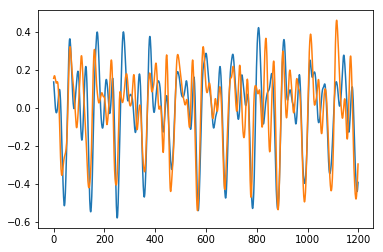

In [45]:
num_input = 439
plt.plot(range(1200), X_train[num_input, :, 1])
plt.plot(range(1200), X_train[num_input, :, 0])

In [46]:
#Add Gaussian Noise
sigma = 0.075
mu = 0
noise = np.random.randn(X_train.shape[0], X_train.shape[1], X_train.shape[2])*sigma + mu
X_train_noise = X_train + noise
X_train_noise = X_train_noise / (X_train_noise.max() - X_train_noise.min())

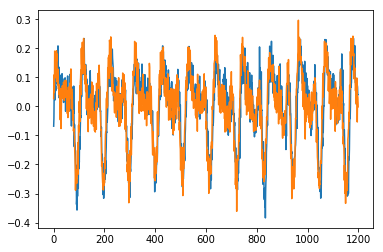

In [47]:
num_input = 4390
plt.plot(range(1200), X_train_noise[num_input, :, 1])
plt.plot(range(1200), X_train_noise[num_input, :, 0])

In [48]:
model = autoencoder((1200, 2))

In [18]:
optm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=3*10**(-4))
model.compile(loss= "mse", 
              optimizer=optm, 
              metrics=["mse"])

In [19]:
filepath="weight_3.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_mean_squared_error', 
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]
history = model.fit(X_train_noise, X_train, 
                    epochs=50, 
                    batch_size=128, 
                    validation_split=0.25, 
                    callbacks=callbacks_list)

Train on 15111 samples, validate on 5037 samples
Epoch 1/50
15111/15111 [==============================] - 56s 4ms/step - loss: 0.0628 - mean_squared_error: 0.0197 - val_loss: 0.0508 - val_mean_squared_error: 0.0084

Epoch 00001: val_mean_squared_error improved from inf to 0.00845, saving model to weight_3.hdf5
Epoch 2/50
15111/15111 [==============================] - 54s 4ms/step - loss: 0.0475 - mean_squared_error: 0.0061 - val_loss: 0.0442 - val_mean_squared_error: 0.0041

Epoch 00002: val_mean_squared_error improved from 0.00845 to 0.00406, saving model to weight_3.hdf5
Epoch 3/50
15111/15111 [==============================] - 54s 4ms/step - loss: 0.0425 - mean_squared_error: 0.0037 - val_loss: 0.0408 - val_mean_squared_error: 0.0034

Epoch 00003: val_mean_squared_error improved from 0.00406 to 0.00336, saving model to weight_3.hdf5
Epoch 4/50
15111/15111 [==============================] - 54s 4ms/step - loss: 0.0392 - mean_squared_error: 0.0032 - val_loss: 0.0375 - val_mean_square


Epoch 00032: val_mean_squared_error improved from 0.00187 to 0.00184, saving model to weight_3.hdf5
Epoch 33/50
15111/15111 [==============================] - 57s 4ms/step - loss: 0.0048 - mean_squared_error: 0.0019 - val_loss: 0.0049 - val_mean_squared_error: 0.0019

Epoch 00033: val_mean_squared_error did not improve from 0.00184
Epoch 34/50
15111/15111 [==============================] - 54s 4ms/step - loss: 0.0047 - mean_squared_error: 0.0019 - val_loss: 0.0047 - val_mean_squared_error: 0.0019

Epoch 00034: val_mean_squared_error did not improve from 0.00184
Epoch 35/50
15111/15111 [==============================] - 54s 4ms/step - loss: 0.0046 - mean_squared_error: 0.0018 - val_loss: 0.0046 - val_mean_squared_error: 0.0019

Epoch 00035: val_mean_squared_error did not improve from 0.00184
Epoch 36/50
15111/15111 [==============================] - 54s 4ms/step - loss: 0.0045 - mean_squared_error: 0.0018 - val_loss: 0.0044 - val_mean_squared_error: 0.0018

Epoch 00036: val_mean_square

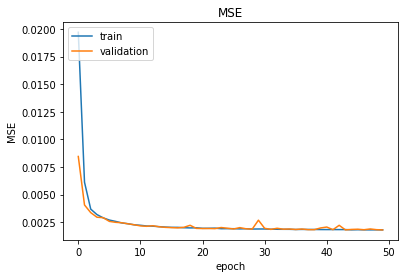

In [20]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

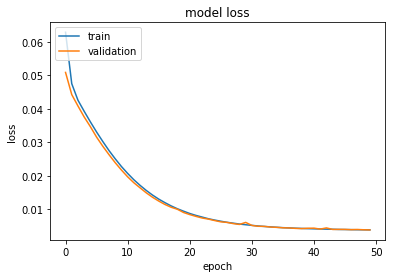

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
filepath="weight_3.hdf5"
model.load_weights(filepath)

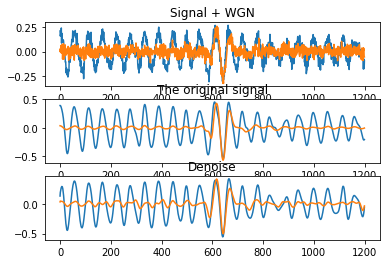

In [20]:
#Predict test set
predict_num = 1000
X_predict = X_train_noise[predict_num]
predict_res = model.predict(np.expand_dims(X_predict, axis=0))

plt.subplot(3, 1, 1)
plt.plot(range(1200), X_train_noise[predict_num, :, 0])
plt.plot(range(1200), X_train_noise[predict_num, :, 1])
plt.title('Signal + WGN')
plt.subplot(3, 1, 2)
plt.plot(range(1200), X_train[predict_num, :, 0])
plt.plot(range(1200), X_train[predict_num, :, 1])
plt.title('The original signal')
plt.subplot(3, 1, 3)
plt.plot(range(1200), predict_res[0][:, 0])
plt.plot(range(1200), predict_res[0][:, 1])
plt.title('Denoise')
plt.show()

In [21]:
layer_out = model.layers[10].output

newlayer = UpSampling1D(4)(layer_out)
newlayer = Conv1D(64, 4, padding='same',
                    kernel_initializer='glorot_uniform',
                    kernel_regularizer=l2(1e-4))(newlayer)
newlayer = MaxPooling1D(pool_size=2)(newlayer)
#newlayer = UpSampling1D(2)(newlayer)

newlayer = Conv1D(256, 4, padding='same',
                    kernel_initializer='glorot_uniform',
                    kernel_regularizer=l2(1e-4))(newlayer)
newlayer = MaxPooling1D(pool_size=2)(newlayer)

newlayer = Activation('relu')(newlayer)
newlayer = Conv1D(128, 4, padding='same',
                    kernel_initializer='glorot_uniform',
                    kernel_regularizer=l2(1e-4))(newlayer)
newlayer = MaxPooling1D(pool_size=2)(newlayer)

newlayer = Activation('relu')(newlayer)
newlayer = Conv1D(64, 4, padding='same',
                    kernel_initializer='glorot_uniform',
                    kernel_regularizer=l2(1e-4))(newlayer)
newlayer = MaxPooling1D(pool_size=2)(newlayer)

newlayer = Activation('relu')(newlayer)
newlayer = Conv1D(16, 4, padding='same',
                    kernel_initializer='glorot_uniform',
                    kernel_regularizer=l2(1e-4))(newlayer)
#newlayer = GlobalAveragePooling1D()(newlayer)

newlayer = Flatten()(newlayer)
newlayer = Dense(64, activation='relu')(newlayer)
newlayer = Dense(16, activation='relu')(newlayer)

out = Dense(1, activation='relu', 
               kernel_initializer='glorot_uniform')(newlayer)

newmodel = Model(input=model.input, output=out)

# Freeze the layers
for layer in newmodel.layers[:10]:
    layer.trainable = False


/Users/xufanxiong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [22]:
newmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1200, 2)           0         
_________________________________________________________________
activation_1 (Activation)    (None, 1200, 2)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1200, 16)          144       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 600, 16)           0         
_________________________________________________________________
activation_2 (Activation)    (None, 600, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 600, 32)           2080      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 300, 32)           0         
__________

In [23]:
optm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=3*10**(-4))
newmodel.compile(loss= "mse", 
              optimizer=optm, 
              metrics=["mse"])

In [24]:
Y_train.shape

(20148, 1)

In [25]:
filepath="weight_3_3.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]
history = newmodel.fit(X_train, Y_train, 
                    epochs=50, 
                    batch_size=128, 
                    validation_split=0.25, 
                    callbacks=callbacks_list)

Train on 15111 samples, validate on 5037 samples
Epoch 1/50
15111/15111 [==============================] - 88s 6ms/step - loss: 0.0625 - mean_squared_error: 0.0177 - val_loss: 0.0498 - val_mean_squared_error: 0.0058

Epoch 00001: val_loss improved from inf to 0.04979, saving model to weight_3_3.hdf5
Epoch 2/50
15111/15111 [==============================] - 87s 6ms/step - loss: 0.0504 - mean_squared_error: 0.0075 - val_loss: 0.0456 - val_mean_squared_error: 0.0039

Epoch 00002: val_loss improved from 0.04979 to 0.04563, saving model to weight_3_3.hdf5
Epoch 3/50
15111/15111 [==============================] - 87s 6ms/step - loss: 0.0465 - mean_squared_error: 0.0060 - val_loss: 0.0419 - val_mean_squared_error: 0.0027

Epoch 00003: val_loss improved from 0.04563 to 0.04185, saving model to weight_3_3.hdf5
Epoch 4/50
15111/15111 [==============================] - 87s 6ms/step - loss: 0.0430 - mean_squared_error: 0.0051 - val_loss: 0.0411 - val_mean_squared_error: 0.0047

Epoch 00004: val_lo

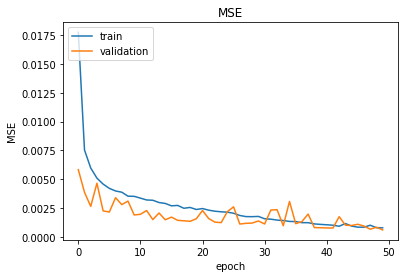

In [26]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

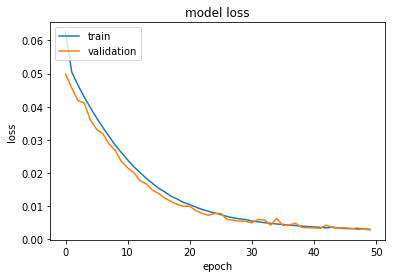

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
newmodel.load_weights('weight_3_3.hdf5')

In [26]:
Y_test1.shape

(690, 1)

In [29]:
#Evaluate
eva = newmodel.evaluate(X_test1, Y_test1, batch_size=32, verbose=1, sample_weight=None)
print('loss = ' + str(eva[0]))
print('Test MSE = ' + str(eva[1]))

690/690 [==============================] - 1s 2ms/step
loss = 0.002920333798839778
Test MSE = 0.0007183198093696484


The avarage predict error:  0.019127011639330196


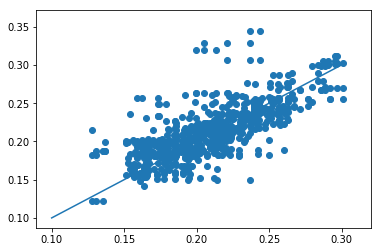

In [55]:
Y_pred = newmodel.predict(X_test1)
plt.figure
plt.scatter(Y_test1, Y_pred)
plt.plot((0.1,0.3), (0.1,0.3))
Y_error = abs(Y_pred - Y_test1)
print('The avarage predict error: ', np.mean(Y_error))
#print('The mean squared error:', metrics.mean_squared_error(Y_test1, Y_pred))

The avarage predict error:  0.06421591868480643


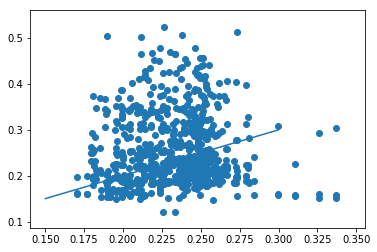

In [58]:
Y_pred = newmodel.predict(X_test2)
plt.figure
plt.scatter(Y_test2, Y_pred)
plt.plot((0.15,0.3), (0.15,0.3))
Y_error = abs(Y_pred - Y_test2)
print('The avarage predict error: ', np.mean(Y_error))
#print('The mean squared error:', metrics.mean_squared_error(Y_test1, Y_pred))